# **讀入數據到path**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils.data_utils import get_file
import os

path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')
print (path)

180224/174693 [==============================] - 1s 3us/step
/root/.keras/datasets/alice.txt


In [ ]:
import numpy as np
np.random.seed(13)

from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
import numpy as np
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
# from keras.utils.visualize_util import model_to_dot, plot
# from gensim.models.doc2vec import Word2Vec

import gensim

# **將獨特字放入V**

In [ ]:

corpus = open(path).readlines()
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
V = len(tokenizer.word_index) + 1
V

3532

# **Define Skipgram Architecture**
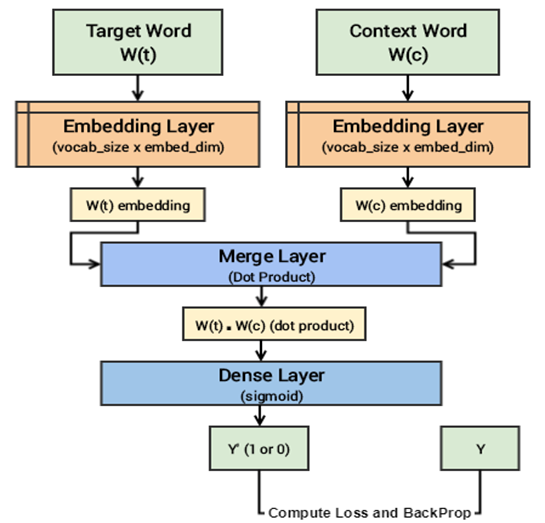

In [ ]:
dim_embedddings = 128

# inputs (Target Words)
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V, dim_embedddings)(w_inputs)

# context (Context Words)
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V, dim_embedddings)(c_inputs)
# Dot Product Layer
o = Dot(axes=2)([w, c])
# Reshape and Sigmoid
o = Reshape((1,), input_shape=(1, 1))(o)
o = Activation('sigmoid')(o)

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
SkipGram.compile(loss='binary_crossentropy', optimizer='adam')



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       452096      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       452096      input_2[0][0]                    
______________________________________________________________________________________________

# **訓練5個迴圈**

In [ ]:
for _ in range(5):
    loss = 0.
    for i, doc in enumerate(tokenizer.texts_to_sequences(corpus)):
        data, labels = skipgrams(sequence=doc, vocabulary_size=V, window_size=5, negative_samples=5.)
        #data, labels = skipgrams(sequence=doc, vocabulary_size=V, window_size=1, negative_samples=0.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        
        if x:
            loss += SkipGram.train_on_batch(x, y)

    print(loss)

2239.3402537554502
715.1303065251559
612.0185482297093
559.1579732950777
522.3202165160328


# **賦予每個獨特字Embeddings**

In [ ]:
d={}

vectors = SkipGram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    d[word]=list(vectors[i, :])


# **'city'這個字的 Embedding, use 128 dimensions**

In [ ]:
print(d['city'])

[0.06642605, -0.0038894387, 0.07037845, 0.024644228, -0.028304042, -0.0016328065, -0.038721554, 0.021821, 0.08288965, -0.057539705, 0.008236726, -0.08191217, 0.09561642, -0.009962163, -0.060623944, -0.09675739, -0.032023575, 0.08888652, 0.005465723, 0.029807903, 0.022680443, 0.0899229, 0.03337777, 0.07952033, 0.047005393, -0.07297049, -0.0026619954, 0.0071692583, -0.0017377195, -0.07407175, 0.03252421, 0.04316332, 0.020870453, -0.074513145, 0.07960416, -0.015114214, 4.7912785e-05, -0.012523647, -0.06273786, -0.10572753, -0.06213578, 0.031934403, 0.004483229, -0.035737865, -0.052875407, 0.035594765, 0.04398477, -0.059512246, -0.001272118, 0.030909272, -0.06282549, -0.05226511, 0.089621164, -0.06627092, -0.07319784, 0.016375462, 0.02003087, 0.0059759156, -0.076826565, 0.014726493, 0.018697074, 0.07850492, 0.075052254, 0.08883905, 0.07797641, -0.019329064, 0.08415482, 0.06999334, 0.08306634, -0.07982025, 0.005761305, 0.06254883, 0.026718939, -0.0032530902, -0.046953954, 0.03581188, 0.0850

# **句子之間的距離**

In [ ]:
def avg_sentence_vector(words, model, num_features):
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    for word in words:
        if word in model.keys():
            featureVec = np.add(featureVec, model[word])

    return featureVec

# **例句一**

In [ ]:
sentence1 = ['i','will','be','eating','tea']
sentence2 = ['i','will','be','drinking','coffee']

In [ ]:
feature1 = avg_sentence_vector(sentence1,d,128)
feature2 = avg_sentence_vector(sentence2,d,128)

# **COSINE DISTANCE**

In [ ]:
from scipy.spatial.distance import cosine
print(cosine(feature1,feature2))

0.032791733741760254


# **例句2**

In [ ]:
sentence3 = ['I','am','walking','to','America']
sentence4 = ['I','am','going','to','Bharat']

In [ ]:
feature3 = avg_sentence_vector(sentence3,d,128)
feature4 = avg_sentence_vector(sentence4,d,128)

In [ ]:
print(cosine(feature3,feature4))

0.04711228609085083


# ZIP and *

In [ ]:
res = [['a', 'b', 'c'], [1, 2, 3]]

for x in zip(*res):
  print (x)

('a', 1)
('b', 2)
('c', 3)


In [ ]:
for x in zip(['a', 'b', 'c'], [1, 2, 3]):
  print (x)

('a', 1)
('b', 2)
('c', 3)


In [ ]:
data = [[1,2],[2,3],[3,4]]
print (*data)

x = [np.array(x) for x in zip(*data)]
print (x)
type(x)

[1, 2] [2, 3] [3, 4]
[array([1, 2, 3]), array([2, 3, 4])]


list

In [ ]:
import numpy as np
data = [[1,2],[2,3],[3,4]]
for x in zip(*data):
  y = np.array(x)
print(y)
z = [np.array(x) for x in zip(*data)]
print(z)

[2 3 4]
[array([1, 2, 3]), array([2, 3, 4])]
